In [1]:
# Street food image calssifier - EDA Notebook
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
print("Device count:", torch.cuda.device_count())

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

if torch.cuda.is_available():
    device_id = 0  # usually 0 if you have one GPU
    total_mem = torch.cuda.get_device_properties(device_id).total_memory
    print(f"Total GPU memory: {total_mem / (1024**3):.2f} GB")

    reserved_mem = torch.cuda.memory_reserved(device_id)
    allocated_mem = torch.cuda.memory_allocated(device_id)
    print(f"Currently Reserved: {reserved_mem / (1024**3):.2f} GB")
    print(f"Currently Allocated: {allocated_mem / (1024**3):.2f} GB")



PyTorch version: 2.7.1+cu126
CUDA available: True
CUDA version: 12.6
cuDNN version: 90501
Device count: 1
GPU Name: NVIDIA GeForce RTX 2080
Total GPU memory: 8.00 GB
Currently Reserved: 0.00 GB
Currently Allocated: 0.00 GB


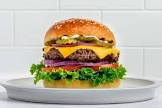

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=162x108 at 0x7B109ED94A10>


In [2]:
from PIL import Image
im = Image.open('../data/train_images/burger/0004_burger.jpg')
im.show()
print(im)
### so we see that the images are RGB and are 162x108

In [3]:
from torchvision import transforms
from torch.utils.data import random_split

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.333)),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1 ), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5, fill=0),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random'),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

img_tensor = train_transform(im)
print(img_tensor.shape)  

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder("../data/train_images", transform=train_transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply val transform to validation subset
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

torch.Size([3, 224, 224])


In [4]:
from torchvision import models


model_self = 0

if model_self:
    ### Make_own CNN
    class CNN(nn.Module):
        def __init__(self, num_classes):
            super(CNN, self).__init__()

            # 1st convolution layer: 3 input channels (RGB), 32 output filters
            self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)

            # Pooling layer: halves the spatial dimensions
            self.pool = nn.MaxPool2d(2, 2)
            # Dropout layer: randomly zeroes some of the elements of the input tensor with probability 0.5
            self.dropout = nn.Dropout(0.5)
            # Batch normalization layer: normalizes the output of the previous layer
            self.batch_norm1 = nn.BatchNorm2d(32)

            # 2nd convolution layer: 32 input channels, 64 output filters
            self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
            self.batch_norm1 = nn.BatchNorm2d(64)

            # 3rd convolution layer: 64 input channels, 128 output filters
            self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
            self.batch_norm1 = nn.BatchNorm2d(128)

            # Fully connected layer (after flattening)
            self.fc1 = nn.Linear(128 * 28 * 28, 256)  
            self.fc2 = nn.Linear(256, num_classes)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))  #1st Conv - ReLU - Pool
            x = self.batch_norm1(x)               # Normalizes the output of the previous layer
            x = self.dropout(x)                   # Dropout set elemtns eaul to zero with probaiblit p
            x = self.pool(F.relu(self.conv2(x)))  #2nd Conv - ReLU - Pool
            x = self.batch_norm2(x)                 
            x = self.dropout(x)                  
            x = self.pool(F.relu(self.conv3(x)))  #3rd Conv - ReLU - Pool
            x = self.batch_norm3(x)
            x = self.dropout(x)                   
            x = x.view(x.size(0), -1)  # Flatten to 1D
            x = F.relu(self.fc1(x))    # Dense layer
            x = self.fc2(x)            # Output layer
            return x
    # Initialize model
    device = torch.device("cuda")
    model = CNN(num_classes=len(full_dataset.classes)).to(device)
            
else:
    # Load pretrained ResNet18
    model = models.resnet50(pretrained=True)

    for name, param in model.named_parameters():
        if "layer4" in name or "fc" in name:  # last block + FC
            param.requires_grad = True
        else:
            param.requires_grad = False

    # Replace final layer for our dataset
    num_classes = len(full_dataset.classes) 
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    # Move to GPU if available
    device = torch.device("cuda")
    model = model.to(device)

/home/federicostachurski/kaggle-projects/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/federicostachurski/kaggle-projects/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
# print(model)

***Let's initialize the CNN***

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.00001)

***Let's train the CNN***

In [21]:
epochs = 100

train_loss_list, train_acc_list = [], []
val_loss_list, val_acc_list = [], []
best_val_acc = 0.0

for epoch in range(epochs):
    # TRAINING
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
    
    train_acc = 100 * train_correct / train_total

    # VALIDATION
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    val_acc = 100 * val_correct / val_total

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_loss/len(train_loader):.4f}, "
          f"Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss/len(val_loader):.4f}, "
          f"Val Acc: {val_acc:.2f}%")
          
    train_loss_list.append(train_loss / len(train_loader))
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss / len(val_loader))
    val_acc_list.append(val_acc)
    # Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        best_model_state = model.state_dict()   

print(f"Best Validation Accuracy: {best_val_acc:.2f}% at epoch {best_epoch+1}")
# Save the model
torch.save(best_model_state, "../CNN_models/pretrained_ResNet50_cnn.pth")


Epoch [1/100] Train Loss: 1.0786, Train Acc: 65.30% | Val Loss: 0.5235, Val Acc: 81.58%
Epoch [2/100] Train Loss: 0.3810, Train Acc: 87.66% | Val Loss: 0.5405, Val Acc: 81.58%
Epoch [3/100] Train Loss: 0.2645, Train Acc: 91.94% | Val Loss: 0.6536, Val Acc: 79.28%
Epoch [4/100] Train Loss: 0.2603, Train Acc: 92.52% | Val Loss: 0.6737, Val Acc: 79.28%
Epoch [5/100] Train Loss: 0.1215, Train Acc: 97.04% | Val Loss: 0.6113, Val Acc: 80.59%
Epoch [6/100] Train Loss: 0.1080, Train Acc: 96.79% | Val Loss: 0.7128, Val Acc: 77.96%
Epoch [7/100] Train Loss: 0.0987, Train Acc: 96.71% | Val Loss: 0.8925, Val Acc: 77.63%
Epoch [8/100] Train Loss: 0.1669, Train Acc: 94.82% | Val Loss: 0.7178, Val Acc: 80.26%
Epoch [9/100] Train Loss: 0.1075, Train Acc: 97.12% | Val Loss: 0.8787, Val Acc: 77.96%
Epoch [10/100] Train Loss: 0.0880, Train Acc: 97.12% | Val Loss: 0.5524, Val Acc: 80.92%
Epoch [11/100] Train Loss: 0.0648, Train Acc: 97.86% | Val Loss: 0.6702, Val Acc: 83.55%
Epoch [12/100] Train Loss: 0.0

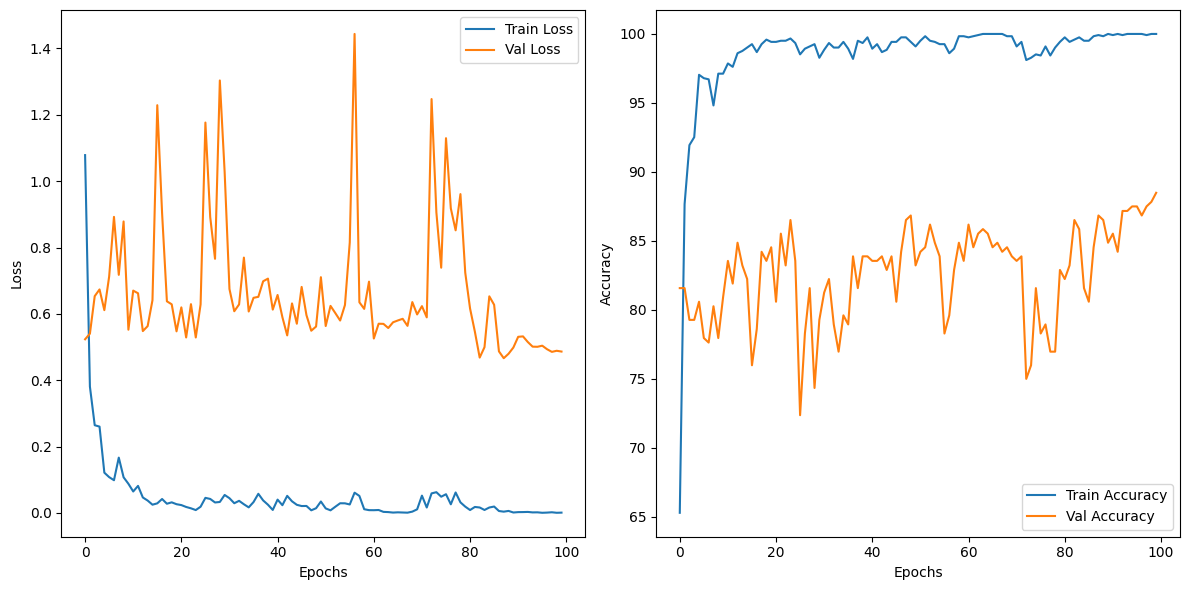

In [22]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

***Let's load the testing data now and see hwo we have done***

In [5]:
# Load the mdoel
model.load_state_dict(torch.load("../CNN_models/pretrained_ResNet50_cnn.pth"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

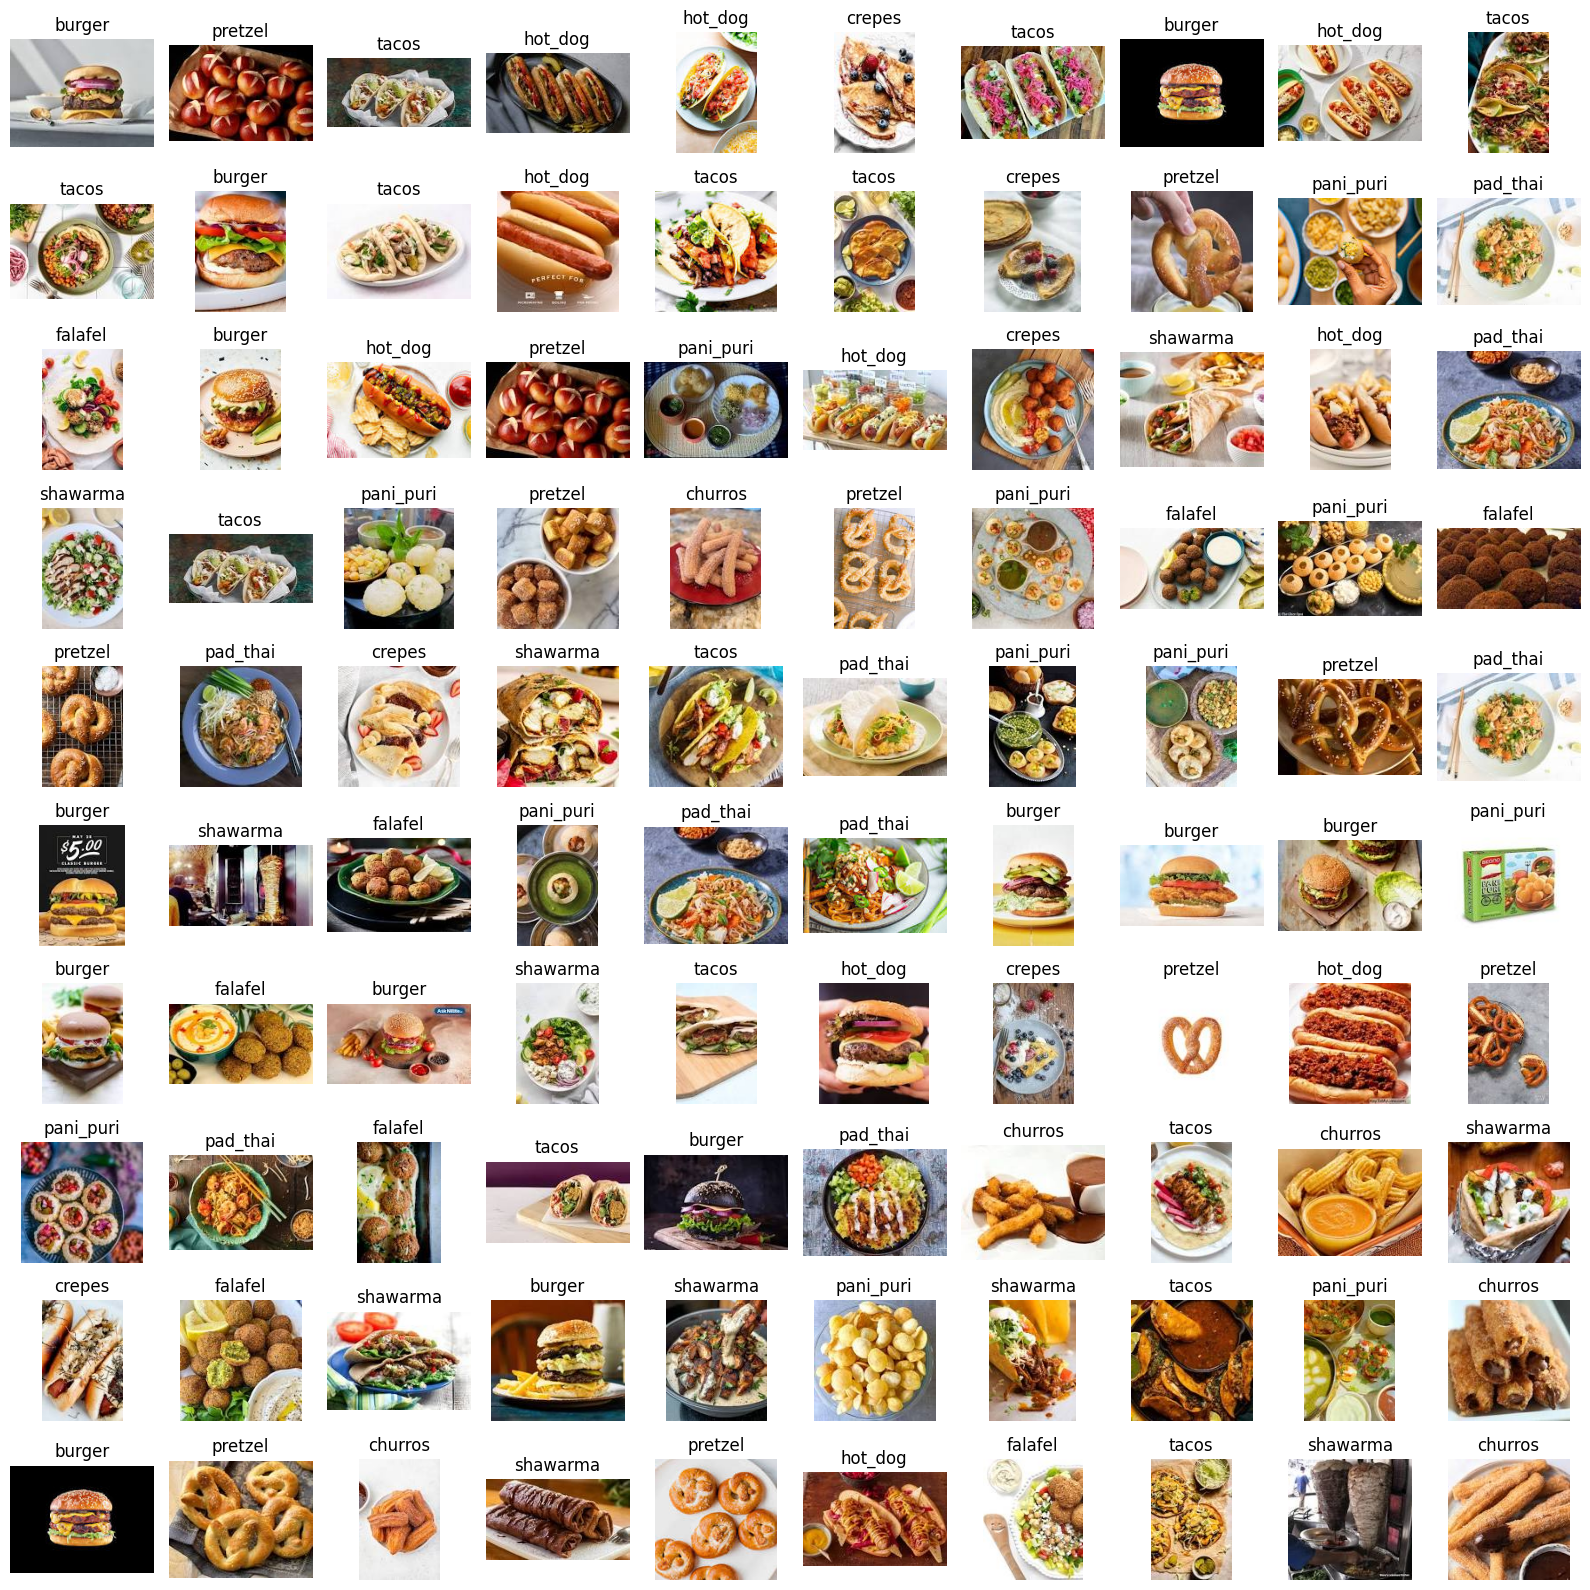

In [6]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch

# Path to test images
test_path = "../data/test_images"

# Get all image files
test_images = [os.path.join(test_path, f) for f in os.listdir(test_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

# Grid size
rows, cols = 10, 10
images_per_page = rows * cols

# Classes from training
class_names = full_dataset.classes
counter = 0 
# Loop through images in chunks
for start in range(0, len(test_images), images_per_page):
    end = start + images_per_page
    images_to_show = test_images[start:end]

    fig, axes = plt.subplots(rows, cols, figsize=(16, 16))
    axes = axes.flatten()

    for idx, img_path in enumerate(images_to_show):
        img = Image.open(img_path).convert('RGB')
        img_tensor = val_transform(img).unsqueeze(0).to(device)  # use validation transform

        # Predict
        with torch.no_grad():
            output = model(img_tensor)
            _, predicted = output.max(1)

        predicted_class = class_names[predicted.item()]

        # Plot image with prediction
        axes[idx].imshow(img)
        axes[idx].set_title(predicted_class, fontsize=12)
        axes[idx].axis('off')

    # Remove empty axes if last page isn't full
    for i in range(len(images_to_show), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
    counter += 1
    if counter == 1:
        break




In [26]:
import pandas as pd
# Classes from training
class_names = full_dataset.classes

# Store results in a list
results = []

# Predict for each image
model.eval()
for img_path in test_images:
    img = Image.open(img_path).convert('RGB')
    img_tensor = val_transform(img).unsqueeze(0).to(device)  # use validation transform

    # Predict
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = output.max(1)

    predicted_class = class_names[predicted.item()]
    image_name = os.path.basename(img_path)  # just the filename

    # Append to results
    results.append([image_name, predicted_class])

# Convert to DataFrame
df = pd.DataFrame(results, columns=["image_id", "label"])

# Save to CSV
output_csv = "../submissions/test_predictions_v1.csv"
df.to_csv(output_csv, index=False)

print(f"Predictions saved to {output_csv}")
print(df.head())

Predictions saved to ../submissions/test_predictions_v1.csv
       image_id    label
0  fc35fba1.jpg   burger
1  188448c7.jpg  pretzel
2  6c5cb4ed.jpg    tacos
3  efc8e485.jpg  hot_dog
4  c35a41d0.jpg  hot_dog
